In [3]:
from __future__  import print_function, division
import pylab as pl
import pandas as pd
import numpy as np
import os
import json
import zipfile
import scipy
from scipy import stats

%pylab inline

Populating the interactive namespace from numpy and matplotlib


$H_0$ : $\frac{W{\mathrm{mean}-M{\mathrm{mean}}}}{M{\mathrm{mean}}} *100 \leq 10\% $

$H_1$ : $\frac{W{\mathrm{mean}-M{\mathrm{mean}}}}{M{\mathrm{mean}}} *100 > 10\% $

In [4]:
!curl https://s3.amazonaws.com/tripdata/201801-citibike-tripdata.csv.zip?accessType=DOWNLOAD > January2018_citibike_tripdata.csv.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22.1M  100 22.1M    0     0  6503k      0  0:00:03  0:00:03 --:--:-- 6503k


In [5]:
#Move file to proper directory
!mv January2018_citibike_tripdata.csv.zip $PUIDATA

In [6]:
#Make sure it is there
!ls $PUIDATA

August2017_citibike_tripdata.csv.zip  aff_download
Borough.zip                           bus_data.txt
Current_Reservoir_Levels.JSON         counties.csv
Current_Reservoir_Levels.csv          inmate_stabbing.csv
January2017_citibike_tripdata.csv.zip inmates.csv
January2018_citibike_tripdata.csv.zip shapefiles.gz
July2017_citibike_tripdata.csv.zip    shapefiles.zip
PLUTO_for_WEB


In [7]:
#Read in the dataset
citibike = pd.read_csv(os.getenv("PUIDATA") + '/January2018_citibike_tripdata.csv.zip')
citibike.head(7)

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
0,970,2018-01-01 13:50:57.4340,2018-01-01 14:07:08.1860,72,W 52 St & 11 Ave,40.767272,-73.993929,505,6 Ave & W 33 St,40.749013,-73.988484,31956,Subscriber,1992,1
1,723,2018-01-01 15:33:30.1820,2018-01-01 15:45:33.3410,72,W 52 St & 11 Ave,40.767272,-73.993929,3255,8 Ave & W 31 St,40.750585,-73.994685,32536,Subscriber,1969,1
2,496,2018-01-01 15:39:18.3370,2018-01-01 15:47:35.1720,72,W 52 St & 11 Ave,40.767272,-73.993929,525,W 34 St & 11 Ave,40.755942,-74.002116,16069,Subscriber,1956,1
3,306,2018-01-01 15:40:13.3720,2018-01-01 15:45:20.1910,72,W 52 St & 11 Ave,40.767272,-73.993929,447,8 Ave & W 52 St,40.763707,-73.985162,31781,Subscriber,1974,1
4,306,2018-01-01 18:14:51.5680,2018-01-01 18:19:57.6420,72,W 52 St & 11 Ave,40.767272,-73.993929,3356,Amsterdam Ave & W 66 St,40.774667,-73.984706,30319,Subscriber,1992,1
5,1602,2018-01-01 21:31:54.1920,2018-01-01 21:58:36.3530,72,W 52 St & 11 Ave,40.767272,-73.993929,482,W 15 St & 7 Ave,40.739355,-73.999318,30106,Subscriber,1968,1
6,722,2018-01-02 07:54:53.6460,2018-01-02 08:06:55.8720,72,W 52 St & 11 Ave,40.767272,-73.993929,228,E 48 St & 3 Ave,40.754601,-73.971879,32059,Subscriber,1978,1


In [8]:
#Show column names
citibike.columns

Index([u'tripduration', u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year', u'gender'],
      dtype='object')

In [9]:
#Remove unecessary data
citibike.drop([u'starttime', u'stoptime', u'start station id',
       u'start station name', u'start station latitude',
       u'start station longitude', u'end station id', u'end station name',
       u'end station latitude', u'end station longitude', u'bikeid',
       u'usertype', u'birth year'],
      axis=1, inplace=True)

In [10]:
#Reveal what is left
citibike.head(7)

,tripduration,gender
0,970,1
1,723,1
2,496,1
3,306,1
4,306,1
5,1602,1
6,722,1


In [11]:
#Show only male data
male= citibike['tripduration'][citibike['gender'] == 1]
male.head()

0    970
1    723
2    496
3    306
4    306
Name: tripduration, dtype: int64

In [12]:
#Show only female data
female= citibike['tripduration'][citibike['gender'] == 2]
female.head()

56     807
62    2432
63    1736
71    1067
74     376
Name: tripduration, dtype: int64

In [13]:
#No gender exists. Could this be due to unavailable info, gender non-conforming populations, or simple refusal to give?
#For sake of hypothesis, we do not include this data in any remaining analyses.
nogender= citibike['tripduration'][citibike['gender'] == 0]
nogender.head()

21      520
22      430
76     1357
77     1364
209     482
Name: tripduration, dtype: int64

In [14]:
men = male.mean()
women = female.mean()

#Convert from average seconds to minutes
men_average = men/60
women_average = women/60

print("The average CitiBike ride for men is %.2f"%men_average,"minutes and for women is %.2f" %women_average, "minutes in January 2018.")

The average CitiBike ride for men is 12.22 minutes and for women is 13.85 minutes in January 2018.


In [15]:
df = pd.DataFrame({'Gender':['Male', 'Female'], 'Average Citibike Ride (minutes)':[men_average, women_average]})

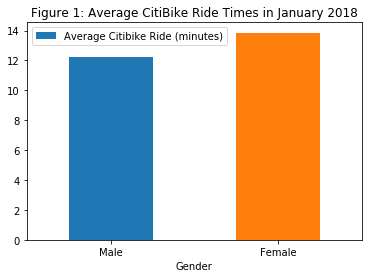

In [16]:
ax = df.plot.bar(x='Gender', y='Average Citibike Ride (minutes)',title= 'Figure 1: Average CitiBike Ride Times in January 2018', rot=0)

Figure 1 shows the average time of a citibike ride amongst men and women in January 2018. Note that women appear to ride longer than men do during this one month.

In [17]:
percent_diff = ((women_average - men_average)/(men_average))*100

In [18]:
print("The percent difference between the avergae ride time of men and women is %.2f"%percent_diff,'%')

The percent difference between the avergae ride time of men and women is 13.39 %


### Since the percent difference, being 13.39%, is greater than 10%, we reject the null hypothesis and accept the alternative.

# All work above was done in HW 4 Part 2. I was received suggestions from sz2404's Citibike Review to calculate a z-score, however, since I am comparing two sample means and do not have a population mean, I will carry out a t-test, where I can compare my two means and see how alike they are.

In [19]:
# Perform the T-test and find the t-statistics and p-value. 
stats.ttest_ind(male,female, equal_var = False)

Ttest_indResult(statistic=-1.8206588209067662, pvalue=0.06865929639030262)